Tamanho do DataFrame: 727 linhas, 24 colunas
Gerando visualização da distribuição de labels...


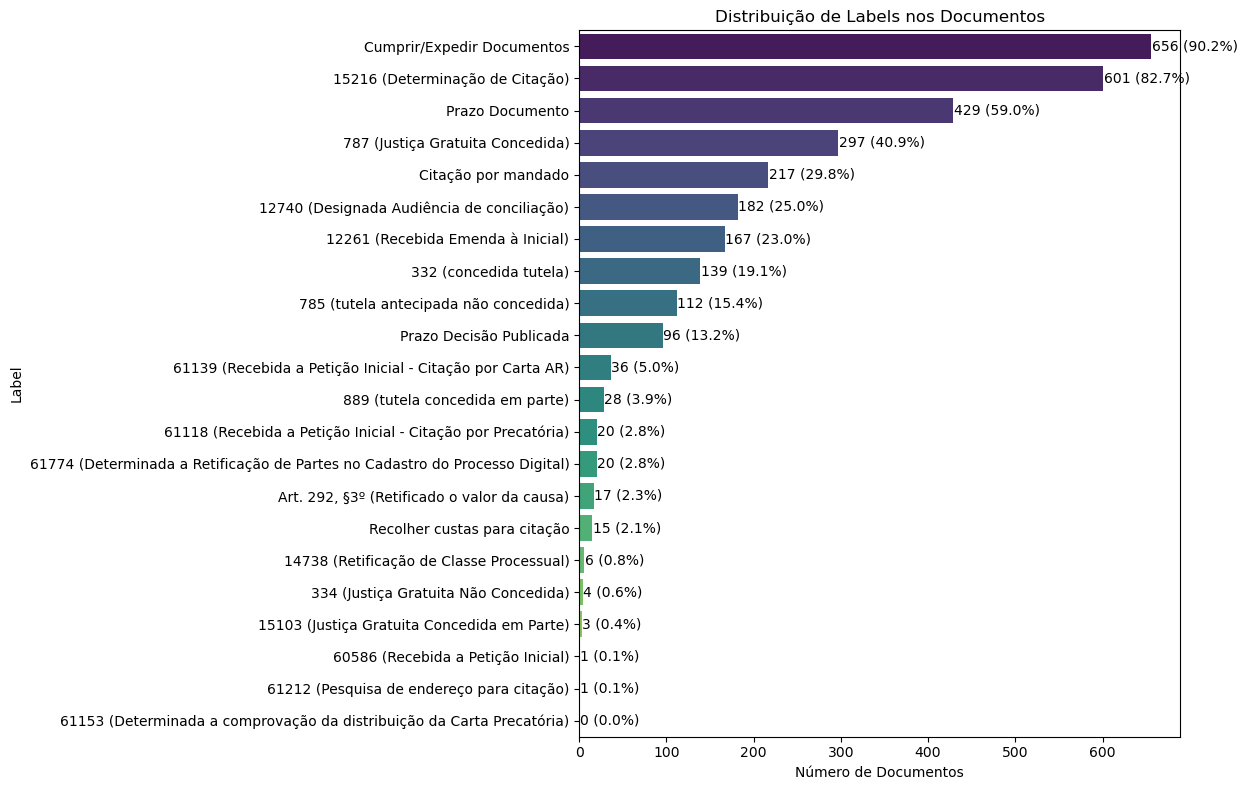

Realizando análise multilabel com OneVsRest...

Resultados da Análise Multilabel:
Accuracy: 0.4292
Hamming Loss: 0.0470
F1 Score (Micro): 0.8763
F1 Score (Macro): 0.4191
F1 Score (Weighted): 0.8517
Jaccard Score (Micro): 0.7798
Jaccard Score (Macro): 0.3560
Jaccard Score (Weighted): 0.7817
Jaccard Score (Samples): 0.7738

Relatório de Classificação:
                                                                             precision    recall  f1-score   support

                                          12261 (Recebida Emenda à Inicial)       0.86      0.64      0.73        47
                                 12740 (Designada Audiência de conciliação)       0.98      0.94      0.96        50
                                   14738 (Retificação de Classe Processual)       0.00      0.00      0.00         2
                                15103 (Justiça Gratuita Concedida em Parte)       0.00      0.00      0.00         0
                                            15216 (Determinaçã

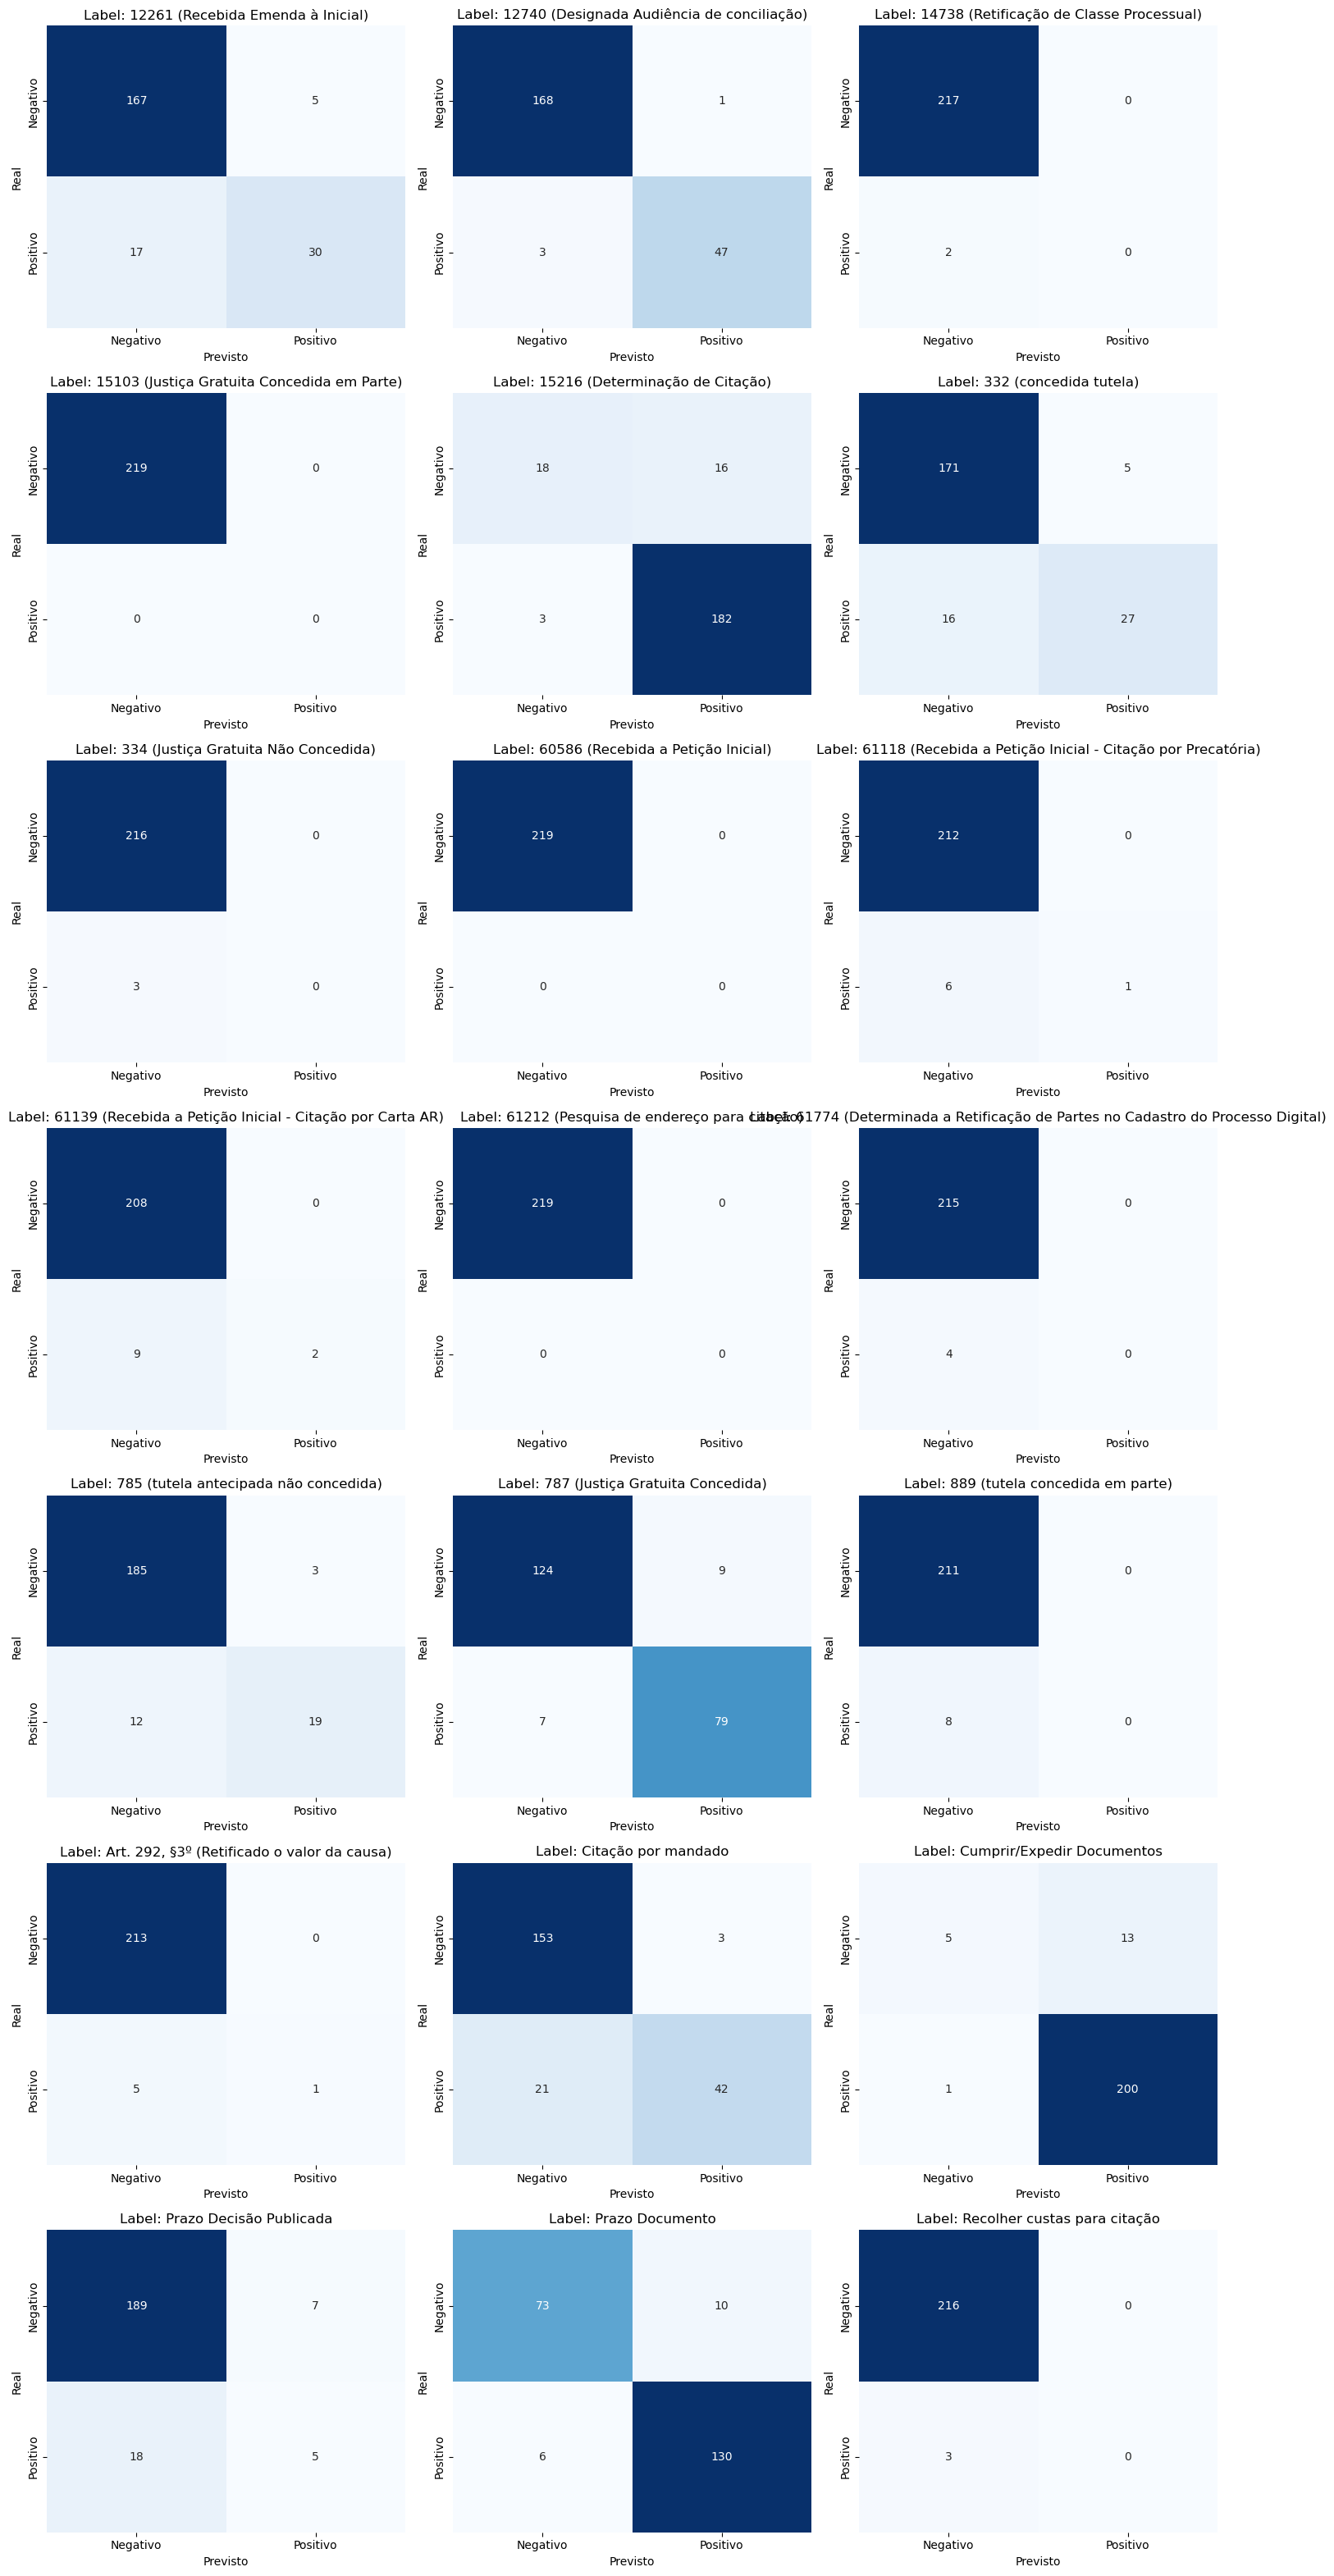

In [8]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import classification_report, accuracy_score, hamming_loss, f1_score, jaccard_score
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import re
import warnings
warnings.filterwarnings("ignore")

# Carregar dados
def carregar_dados(arquivo):
    df = pd.read_csv("/home/guilherme-burzynski-dienes/Documents/UFSC/Artigo multirotulo/testinho2.csv", sep=',')
    return df

# Pré-processar dados
def preprocessar_dados(df):
    
    # Identificar as colunas de label (todas exceto 'Fonte' e 'Content')
    colunas_label = df.columns.difference(['Fonte', 'Content'])
    
    # Criar um conjunto de labels para cada linha
    labels = []
    for _, row in df.iterrows():
        labels_da_linha = []
        for col in colunas_label:
            if row[col] == 1:
                labels_da_linha.append(col)
        labels.append(labels_da_linha)
    
    # Criar um DataFrame com os textos e as respectivas labels
    df_processado = pd.DataFrame({
        'texto': df['Content'],
        'labels': labels
    })
    
    return df_processado, colunas_label

# Realizar a análise multilabel
def realizar_analise_multilabel(df, colunas_label):
    # Dividir em conjunto de treino e teste
    X_train, X_test, y_train, y_test = train_test_split(
        df['texto'], df['labels'], test_size=0.3, random_state=42
    )
    
    # Converter texto para features usando TF-IDF
    vectorizer = TfidfVectorizer(min_df=3, max_df=0.9, ngram_range=(1, 2))
    X_train_tfidf = vectorizer.fit_transform(X_train)
    X_test_tfidf = vectorizer.transform(X_test)
    
    # Binarizar as labels
    mlb = MultiLabelBinarizer()
    y_train_bin = mlb.fit_transform(y_train)
    y_test_bin = mlb.transform(y_test)
    
    # Treinar o classificador OneVsRest
    classifier = OneVsRestClassifier(LinearSVC(random_state=42))
    classifier.fit(X_train_tfidf, y_train_bin)
    
    # Fazer previsões
    y_pred = classifier.predict(X_test_tfidf)
    
    # Calcular métricas
    accuracy = accuracy_score(y_test_bin, y_pred)
    hamming = hamming_loss(y_test_bin, y_pred)
    f1_micro = f1_score(y_test_bin, y_pred, average='micro')
    f1_macro = f1_score(y_test_bin, y_pred, average='macro')
    f1_weighted = f1_score(y_test_bin, y_pred, average='weighted')
    jaccard_micro = jaccard_score(y_test_bin, y_pred, average='micro')
    jaccard_macro = jaccard_score(y_test_bin, y_pred, average='macro')
    jaccard_weighted = jaccard_score(y_test_bin, y_pred, average='weighted')
    jaccard_samples = jaccard_score(y_test_bin, y_pred, average='samples')
    
    # Relatório de classificação para cada label
    target_names = mlb.classes_
    relatorio = classification_report(y_test_bin, y_pred, target_names=target_names, zero_division=0)
    
    return {
        'classifier': classifier,
        'vectorizer': vectorizer,
        'mlb': mlb,
        'accuracy': accuracy,
        'hamming_loss': hamming,
        'f1_micro': f1_micro,
        'f1_macro': f1_macro,
        'f1_weighted': f1_weighted,
        'classification_report': relatorio,
        'y_test_bin': y_test_bin,
        'y_pred': y_pred,
        'target_names': target_names,
        'jaccard_micro': jaccard_micro,
        'jaccard_macro': jaccard_macro,
        'jaccard_weighted': jaccard_weighted,
        'jaccard_samples': jaccard_samples,
    }

# Visualizar a distribuição de labels
def visualizar_distribuicao_labels(df, colunas_label):
    # Calcular contagem de cada label
    contagens = {}
    for col in colunas_label:
        contagens[col] = df['labels'].apply(lambda x: col in x).sum()
    
    # Ordenar por contagem
    contagens_ordenadas = dict(sorted(contagens.items(), key=lambda item: item[1], reverse=True))
    
    # Criar gráfico
    plt.figure(figsize=(12, 8))
    sns.barplot(x=list(contagens_ordenadas.values()), y=list(contagens_ordenadas.keys()), palette='viridis')
    plt.title('Distribuição de Labels nos Documentos')
    plt.xlabel('Número de Documentos')
    plt.ylabel('Label')
    plt.tight_layout()
    
    # Mostrar número e percentual para cada label
    total = len(df)
    for i, (label, count) in enumerate(contagens_ordenadas.items()):
        percentage = (count / total) * 100
        plt.text(count + 0.5, i, f'{count} ({percentage:.1f}%)', va='center')
    
    return plt.gcf()

# Visualizar matriz de confusão
def visualizar_matrix_confusao(resultados):
    # Comparar valores previstos vs reais para cada label
    y_test = resultados['y_test_bin']
    y_pred = resultados['y_pred']
    target_names = resultados['target_names']
    
    n_labels = len(target_names)
    
    # Criar uma figura com múltiplos subplots - um para cada label
    fig, axes = plt.subplots(int(np.ceil(n_labels/3)), 3, figsize=(15, n_labels*1.5))
    axes = axes.flatten()
    
    for i, label in enumerate(target_names):
        if i < len(axes):
            # Calcular valores de matriz de confusão para cada label
            tp = np.sum((y_test[:, i] == 1) & (y_pred[:, i] == 1))
            fp = np.sum((y_test[:, i] == 0) & (y_pred[:, i] == 1))
            fn = np.sum((y_test[:, i] == 1) & (y_pred[:, i] == 0))
            tn = np.sum((y_test[:, i] == 0) & (y_pred[:, i] == 0))
            
            cm = np.array([[tn, fp], [fn, tp]])
            
            # Plotar matriz de confusão
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, ax=axes[i])
            axes[i].set_title(f'Label: {label}')
            axes[i].set_xlabel('Previsto')
            axes[i].set_ylabel('Real')
            axes[i].set_xticklabels(['Negativo', 'Positivo'])
            axes[i].set_yticklabels(['Negativo', 'Positivo'])
    
    # Esconder axes extras se houver
    for j in range(i+1, len(axes)):
        axes[j].axis('off')
    
    plt.tight_layout()
    return plt

# Analisar palavras mais importantes para cada label
def analisar_palavras_importantes(resultados, top_n=10):
    vectorizer = resultados['vectorizer']
    classifier = resultados['classifier']
    mlb = resultados['mlb']
    
    # Obter os nomes dos features (palavras)
    feature_names = np.array(vectorizer.get_feature_names_out())
    
    # Criar dataframe para armazenar as palavras mais importantes
    palavras_importantes = {}
    
    for i, label in enumerate(mlb.classes_):
        # Obter coeficientes para cada label
        coefs = classifier.estimators_[i].coef_[0]
        
        # Obter índices das top palavras positivas (mais associadas com a label)
        top_pos_indices = np.argsort(coefs)[-top_n:]
        
        # Obter as palavras e seus coeficientes
        top_pos_words = [(feature_names[j], coefs[j]) for j in top_pos_indices]
        
        palavras_importantes[label] = top_pos_words
    
    return palavras_importantes

# Função principal
def main():
    # Carregar dados
    arquivo = '/home/guilherme-burzynski-dienes/Documents/UFSC/Artigo multirotulo/testinho2.csv'  # Usar o arquivo CSV fornecido
    df = carregar_dados("/home/guilherme-burzynski-dienes/Documents/UFSC/Artigo multirotulo/testinho2.csv")
    
    # Para fins de teste com apenas uma linha, duplicamos a linha para simular 1500 registros
    if len(df) < 10:
        print(f"Aviso: O DataFrame possui apenas {len(df)} linhas. Duplicando para simular um conjunto maior...")
        df = pd.concat([df] * 1500, ignore_index=True)
        # Adicionar alguma variabilidade aleatória para evitar overfitting
        np.random.seed(42)
        for i in range(len(df)):
            if i % 10 == 0:  # Modificar aleatoriamente 10% dos registros
                # Selecionar aleatoriamente colunas binárias para inverter
                colunas_bin = df.columns[1:-1]  # Todas exceto 'Fonte' e 'Content'
                for col in np.random.choice(colunas_bin, size=np.random.randint(1, 5), replace=False):
                    df.loc[i, col] = 1 - df.loc[i, col]  # Inverter valor (0->1, 1->0)
    
    print(f"Tamanho do DataFrame: {len(df)} linhas, {len(df.columns)} colunas")
    
    # Pré-processar os dados
    df_processado, colunas_label = preprocessar_dados(df)
    
    # Visualizar distribuição de labels
    print("Gerando visualização da distribuição de labels...")
    fig_dist = visualizar_distribuicao_labels(df_processado, colunas_label)
    fig_dist.savefig('distribuicao_labels.png')
    plt.show(fig_dist)
    plt.close(fig_dist)
    
    # Realizar análise multilabel
    print("Realizando análise multilabel com OneVsRest...")
    resultados = realizar_analise_multilabel(df_processado, colunas_label)
    
    # Mostrar resultados
    print("\nResultados da Análise Multilabel:")
    print(f"Accuracy: {resultados['accuracy']:.4f}")
    print(f"Hamming Loss: {resultados['hamming_loss']:.4f}")
    print(f"F1 Score (Micro): {resultados['f1_micro']:.4f}")
    print(f"F1 Score (Macro): {resultados['f1_macro']:.4f}")
    print(f"F1 Score (Weighted): {resultados['f1_weighted']:.4f}")
    print(f"Jaccard Score (Micro): {resultados['jaccard_micro']:.4f}")
    print(f"Jaccard Score (Macro): {resultados['jaccard_macro']:.4f}")
    print(f"Jaccard Score (Weighted): {resultados['jaccard_weighted']:.4f}")
    print(f"Jaccard Score (Samples): {resultados['jaccard_samples']:.4f}")

    
    
    print("\nRelatório de Classificação:")
    print(resultados['classification_report'])
    
    # Visualizar matriz de confusão
    print("Gerando matrizes de confusão...")
    fig_conf = visualizar_matrix_confusao(resultados)
    fig_conf.savefig('matrizes_confusao.png')
    #plt.close(fig_conf)
    
    # Analisar palavras mais importantes
    print("\nPalavras mais importantes para cada label:")
    palavras_importantes = analisar_palavras_importantes(resultados)
    
    for label, words in palavras_importantes.items():
        print(f"\nLabel: {label}")
        for word, coef in words:
            print(f"  {word}: {coef:.4f}")
    # Fazer inferência com novos documentos
    print("\nExemplo de previsão para um novo documento:")
    def fazer_inferencia_arquivo_especifico(caminho_arquivo_inferencia, resultados):
        try:
            # Carregar o arquivo CSV
            print(f"\nCarregando dados para inferência do arquivo: {caminho_arquivo_inferencia}")
            novos_documentos = pd.read_csv(caminho_arquivo_inferencia, sep=',')
            
            # Verificar se as colunas necessárias existem
            if 'Content' not in novos_documentos.columns:
                raise ValueError("O arquivo CSV não contém uma coluna 'Content'.")
            if 'Fonte' not in novos_documentos.columns:
                raise ValueError("O arquivo CSV não contém uma coluna 'Fonte'.")
                
            print(f"Carregados {len(novos_documentos)} documentos para inferência.")
            
            # Extrair a lista de conteúdos para vetorização
            novos_documentos_list = novos_documentos['Content'].dropna().tolist()
            
            # Vetorizar o conteúdo
            novo_tfidf = resultados['vectorizer'].transform(novos_documentos_list)
            
            # Prever os rótulos
            pred = resultados['classifier'].predict(novo_tfidf)
            
            # Converter previsões para rótulos originais
            labels_previstas = resultados['mlb'].inverse_transform(pred)
            
            # Preparar os resultados para salvar
            resultados_inferencia = []
            
            # Exibir resultados com identificador de fonte e rótulos previstos
            for i, (_, row) in enumerate(novos_documentos.iterrows()):
                if i < len(labels_previstas):  # Verificação de segurança
                    fonte = row['Fonte']
                    texto = row['Content']
                    labels = labels_previstas[i]
                    
                    print(f"\nFonte: {fonte}")
                    print(f"Texto: {texto[:100]}..." if len(texto) > 100 else f"Texto: {texto}")
                    print(f"Labels previstas: {', '.join(labels) if labels else 'Nenhuma'}")
                    print("-" * 50)  # Separador para legibilidade
                    
                    # Adicionar aos resultados
                    resultados_inferencia.append({
                        'Fonte': fonte,
                        'Content': texto[:100] + '...' if len(texto) > 100 else texto,
                        'Labels Previstas': labels
                    })
            
            # Criar DataFrame com os resultados
            df_resultados = pd.DataFrame(resultados_inferencia)
            
            # Salvar resultados em um CSV
            arquivo_saida = caminho_arquivo_inferencia.replace('.csv', '_resultados_inferencia.csv')
            df_resultados.to_csv(arquivo_saida, index=False)
            print(f"\nResultados salvos em {arquivo_saida}")
            
            return df_resultados
        
        except Exception as e:
            print(f"Erro ao ler o arquivo CSV: {e}")
            return None
    caminho_arquivo_inferencia = '/home/guilherme-burzynski-dienes/Documents/UFSC/Artigo multirotulo/testes_classificador.csv'
    df_resultados = fazer_inferencia_arquivo_especifico(caminho_arquivo_inferencia, resultados)
if __name__ == "__main__":
    main()